In [1]:
from __future__ import print_function, division
# from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
import torchvision.models as models
# import matplotlib.pyplot as plt
import torch.optim as optim
from PIL import Image
import numpy as np
import random
import torch
import copy
import time
import os

from image_loader import SchoolDataset
from attnNet import *
from helpers import *

In [2]:
dataset = SchoolDataset("./data/y1314_AllSubjects.csv", "./data/imagery/")

x_train, y_train, x_val, y_val, w_train, w_val = train_test_split_regr(dataset, .80)

train = [(k,v, w) for k,v,w in zip(x_train, y_train, w_train)]
val = [(k,v, w) for k,v,w in zip(x_val, y_val, w_val)]


print(len(train))
print(len(val))

dataset_sizes = {}
dataset_sizes['train'] = len(train)
dataset_sizes['val'] = len(val)

batchSize = 4

# Prep the training and validation set
train = torch.utils.data.DataLoader(train, batch_size = batchSize, shuffle = True)
val = torch.utils.data.DataLoader(val, batch_size = batchSize, shuffle = True)


dataloaders = {}
dataloaders['train'] = train
dataloaders['val'] = val

4700
1175


In [26]:
import numpy as np
import random
import torch



class channelMaxPool(torch.nn.Module):
    def __init__(self, in_channels, h, w, batch_size):
        super(channelMaxPool, self).__init__()
        self.batch_size = batch_size
        self.h = h
        self.w = h


    def forward(self, x):
        # torch.reshape(v, (1,2,2))
        x, i = torch.max(x, dim = 1)
        return torch.reshape(x, (x.shape[0], 1, self.h, self.w))


class spatialMaxPool(torch.nn.Module):
    def __init__(self, in_channels, batch_size):
        super(spatialMaxPool, self).__init__()
        self.in_channels = in_channels
        self.batch_size = batch_size

    def forward(self, x):
        x, i = torch.max(x, dim = -1)
        x, i = torch.max(x, dim = -1)
        return torch.reshape(x, (x.shape[0], self.in_channels, 1, 1))


class channelAvgPool(torch.nn.Module):
    def __init__(self, in_channels, h, w, batch_size):
        super(channelAvgPool, self).__init__()
        self.batch_size = batch_size
        self.h = h
        self.w = h


    def forward(self, x):
        x = torch.mean(x, dim = 1)
        return torch.reshape(x, (x.shape[0], 1, self.h, self.w))


class spatialAvgPool(torch.nn.Module):
    def __init__(self, in_channels, batch_size):
        super(spatialAvgPool, self).__init__()
        self.in_channels = in_channels
        self.batch_size = batch_size

    def forward(self, x):
        x = torch.mean(x, dim = -1)
        x = torch.mean(x, dim = -1)
        return torch.reshape(x, (x.shape[0], self.in_channels, 1, 1))



class attnNet(torch.nn.Module):
    def __init__(self, in_channels, h, w, batch_size, resnet):
        super(attnNet, self).__init__()

        # Normal resnet stuff
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.linear = torch.nn.Linear(in_features=2048, out_features=1, bias = True)


        # Attention layers
        self.sMP = spatialMaxPool(in_channels = 2048, batch_size = batch_size)
        self.cMP = channelMaxPool(in_channels = 2048, h = 7, w = 7, batch_size = batch_size)
        self.sAP = spatialAvgPool(in_channels = 2048, batch_size = batch_size)
        self.cAP = channelAvgPool(in_channels = 2048, h = 7, w = 7, batch_size = batch_size)
        # self.out_channels = int(in_channels/16)
        self.out_channels = in_channels
        self.convR_M = torch.nn.Conv2d(in_channels = 2048, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convA_M = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convB_M = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (3,3), bias=True, padding = 1)
        self.convC_M = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (7,7), bias=True, padding = 3)
        self.convE_M = torch.nn.Conv2d(in_channels = self.out_channels * 3, out_channels = 2048, kernel_size = (1,1), bias=True)
        
        self.convR_A = torch.nn.Conv2d(in_channels = 2048, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convA_A = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (1,1), bias=True)
        self.convB_A = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (3,3), bias=True, padding = 1)
        self.convC_A = torch.nn.Conv2d(in_channels = self.out_channels, out_channels = self.out_channels, kernel_size = (7,7), bias=True, padding = 3)
        self.convE_A = torch.nn.Conv2d(in_channels = self.out_channels * 3, out_channels = 2048, kernel_size = (1,1), bias=True)

        self.bn2 = torch.nn.BatchNorm2d(2048)

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):

        # print(x.shape)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.avgpool(out)
        # out = out.flatten(start_dim=1)
        # out = self.linear(out)

        # print(out.shape)


        # Max Pooling
        fsM = self.sMP(out)
        fcM = self.cMP(out)
        fscM = torch.mul(fsM, fcM)
        rM = self.convR_M(fscM)
        aM = self.convA_M(rM)
        bM = self.convB_M(rM)
        cM = self.convC_M(rM)
        catM = torch.cat((aM,bM,cM), dim = 1)
        eM = self.convE_M(catM)


        # Avg Pooling
        fsA = self.sAP(out)
        fcA = self.cAP(out)
        fscA = torch.mul(fsA, fcA)
        rA = self.convR_A(fscA)
        aA = self.convA_A(rA)
        bA = self.convB_A(rA)
        cA = self.convC_A(rA)
        catA = torch.cat((aA,bA,cA), dim = 1)
        eA = self.convE_A(catA)

        added = torch.add(eA, eM)

        added_norm = self.bn2(added)

        out = self.sigmoid(added_norm)

        # # print("A: ", out)

        # out = self.avgpool(out)

        # # print("B: ", out.shape)

        # out = out.flatten(start_dim=1)
        # out = self.linear(out)

        return out

In [27]:
resnet50 = models.resnet50()
IN_CHANNELS = 3
H = 224
W = 224

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = attnNet(IN_CHANNELS, H, W, batchSize, resnet50)
model = model.to(device)
criterion = torch.nn.L1Loss(reduction = 'mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
checkpoint = torch.load("./trained_models/schoolCNN_L0001_r50_wl_v4.torch")
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

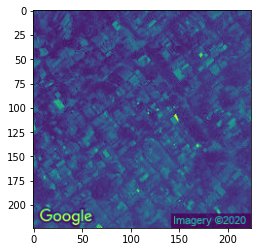

In [30]:
import matplotlib.pyplot as plt

plt.imshow(dataset[100][0][0])
# plt.savefig("./figures/im40_og.png")

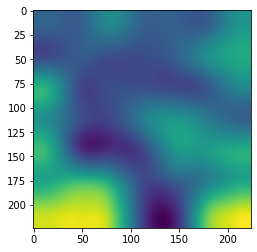

In [29]:
import cv2
import numpy as np

attn = model(dataset[100][0].unsqueeze(0).to(device)).cpu().detach().numpy()#.tolist()[0][0]
res = cv2.resize(attn[0][0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(res)
# plt.savefig("./figures/im40_attn.png")

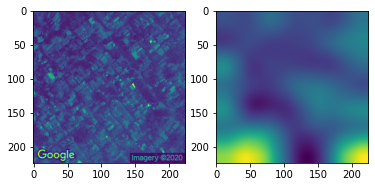

In [19]:
plt.subplot(1, 2, 1)
plt.imshow(dataset[100][0][0])

plt.subplot(1, 2, 2)
attn = model(dataset[100][0].unsqueeze(0).to(device)).cpu().detach().numpy()#.tolist()[0][0]
res = cv2.resize(attn[0][0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
plt.imshow(res)

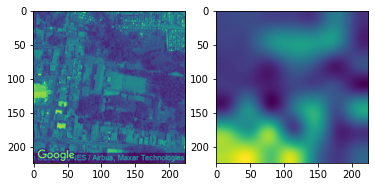

In [31]:
def plot_attn_og(image_num):
    plt.subplot(1, 2, 1)
    plt.imshow(dataset[image_num][0][0])

    plt.subplot(1, 2, 2)
    attn = model(dataset[image_num][0].unsqueeze(0).to(device)).cpu().detach().numpy()#.tolist()[0][0]
    res = cv2.resize(attn[0][0], dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    plt.imshow(res)


plot_attn_og(3)